In [2]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

Again load data and prepare as for manual stage (see data_analysis.ipynb)

In [3]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])

In [52]:
def prepare_data_with_dynamic_window(df_input, window=1, test_size=0.2):
    X, y = [], []
    df = df_input.copy()
    df_grouped = df.groupby(["case"]).size()
    df_idx = df_grouped[df_grouped>=window+1].index
    scal_model = MinMaxScaler()
    df_scaled = scal_model.fit_transform(df.iloc[:, 29:43])
    df.iloc[:, 29:43] = df_scaled
    for i in df_idx:
        for j in range(len(df.loc[(i)])-window):
            wind = df.loc[(i, j): (i, j+window-1)]
            X.append(wind.iloc[:, :47])
            y.append(df.loc[(i, j+window)].iloc[29:42])
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = prepare_data_with_dynamic_window(df, window=1)
print("Test train shapes:", X_train.shape,
X_test.shape)
X_train = X_train.reshape(-1, 47)
X_test = X_test.reshape(-1, 47)

Test train shapes: (3356, 1, 47) (840, 1, 47)


Firstly we will try to predict one window 

2022-12-03 01:24:57,847 - ApiComposer - Initial pipeline was fitted in 1.6 sec.
2022-12-03 01:24:57,852 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 5 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-12-03 01:24:57,871 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-03 01:28:17,051 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [03:19<?, ?gen/s]

2022-12-03 01:28:17,055 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


  0%|          | 25/100000 [01:40<111:08:53,  4.00s/trial, best loss: 0.054252403788001835]
2022-12-03 01:30:00,484 - ApiComposer - Hyperparameters tuning finished
2022-12-03 01:30:00,629 - ApiComposer - Model generation finished
2022-12-03 01:30:00,729 - FEDOT logger - Final pipeline was fitted
2022-12-03 01:30:00,730 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rfr]}


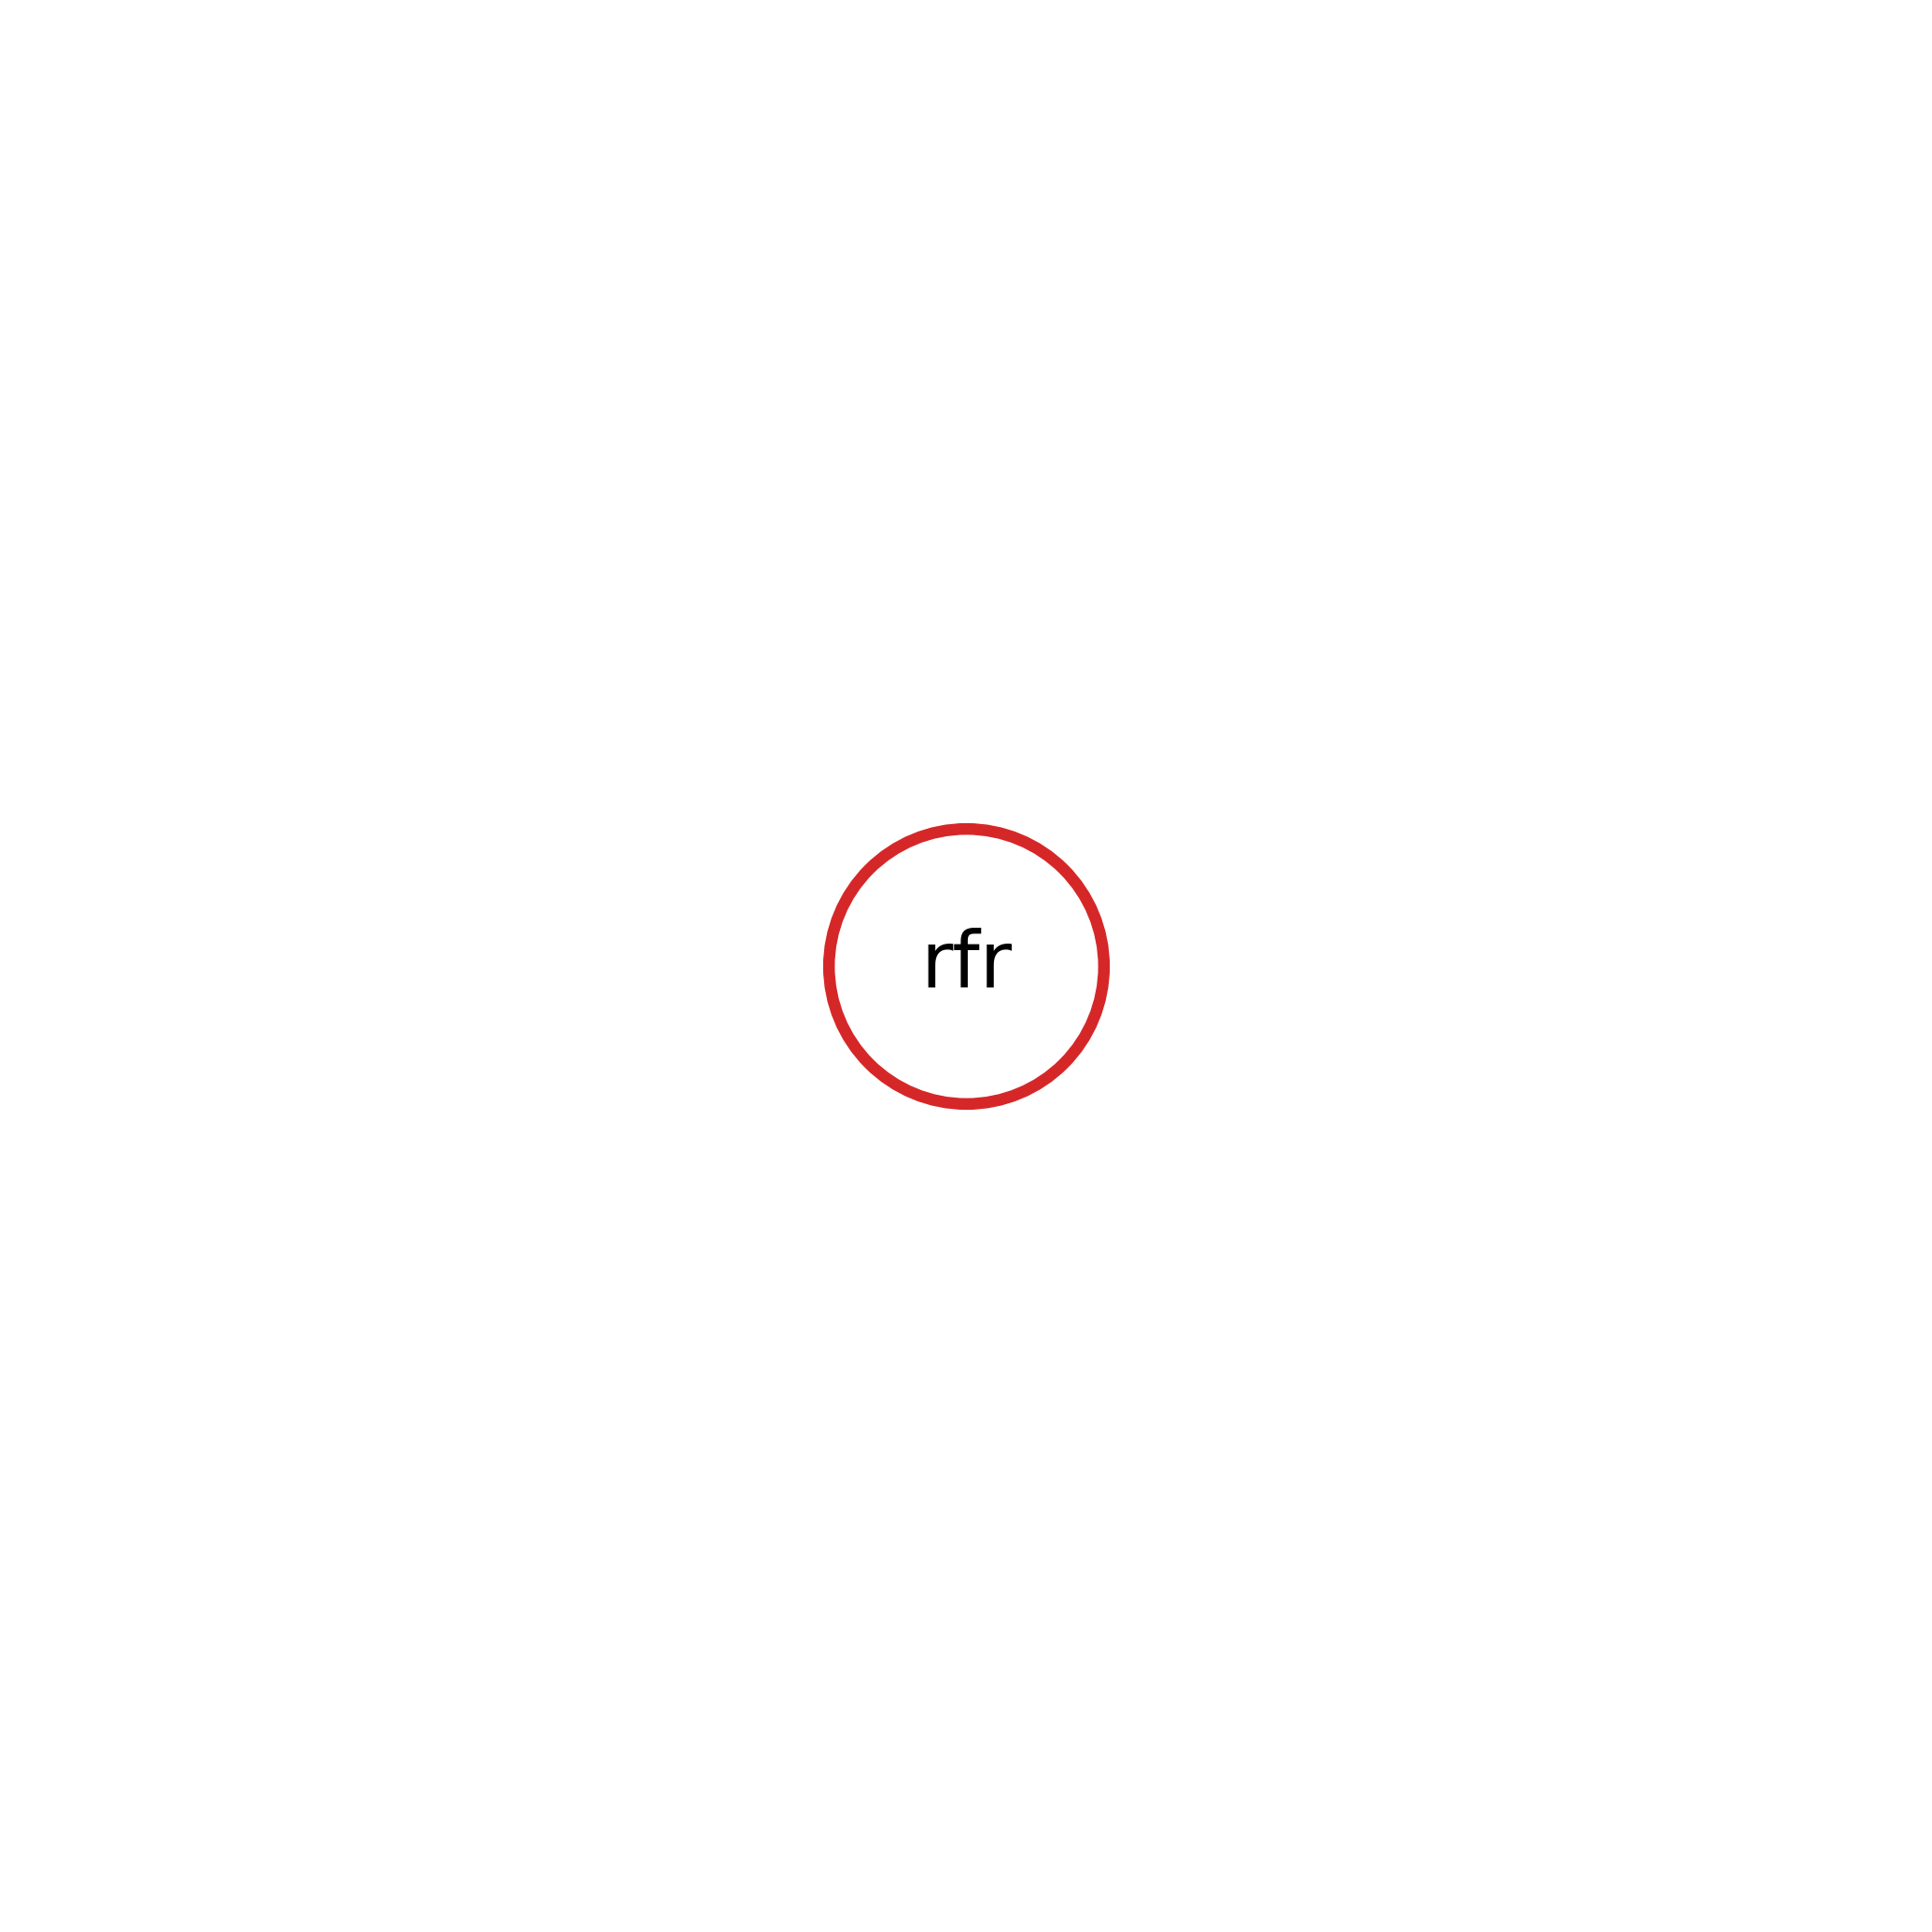

SAVED Т
2022-12-03 01:30:06,734 - ApiComposer - Initial pipeline was fitted in 4.1 sec.
2022-12-03 01:30:06,738 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 5 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-12-03 01:30:06,769 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-03 01:32:39,831 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [02:33<?, ?gen/s]

2022-12-03 01:32:39,836 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


  0%|          | 17/100000 [02:33<251:03:11,  9.04s/trial, best loss: 0.0175556966592004] 
2022-12-03 01:35:52,675 - ApiComposer - Hyperparameters tuning finished
2022-12-03 01:35:52,850 - ApiComposer - Model generation finished


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2856 but corresponding boolean dimension is 2285

In [53]:
models = {}
dinam_fact_columns = df.columns[29:42][0]
for param_idx, param_name in enumerate(dinam_fact_columns):
    model = Fedot(problem='regression', timeout=5, n_jobs=-1)
    obtained_pipeline = model.fit(features=X_train, target=y_train[:, param_idx])
    obtained_pipeline.show()
    models[param_name] = (model, obtained_pipeline)
    obtained_pipeline.save(f"models/fedot_regress_one_window_param_{param_idx}.json")
    print(f"SAVED {param_name}")


Here we will evaluate our model

In [ ]:
models

In [51]:
print("Scaling + RandomForestRegression results:")
y_pred = model_oneparam.predict(X_test)
mask = ~np.isnan(y_test[:, 0])
y_check = y_test[mask]
y_pred = y_pred[mask]
r2_res = r2_score(y_check, y_pred, multioutput="raw_values")
mse = mean_squared_error(y_check, y_pred)
print("R2    ", r2_res)
print("MSE ", mse**(1/2))

Scaling + RandomForestRegression results:


IndexError: boolean index did not match indexed array along dimension 0; dimension is 524 but corresponding boolean dimension is 840

Increase window